Original Notebook: https://www.kaggle.com/pourchot/simple-neural-network

## Simple Neural Networks - Modifications

In this notebook, we will evaluate the performance of a slightly modified version of  the Neural Network presented in the notebook https://www.kaggle.com/pourchot/simple-neural-network. Some hyperparameters have been obtained through hyperparameters optimization using Keras Tuner.

In [1]:
# load pycodestyle-magic to be compliant with PEP8 conventions
%load_ext pycodestyle_magic

In [2]:
# activate pycodestyle for each cell
%pycodestyle_on

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
import gc
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras import layers
from tensorflow.keras import activations,callbacks
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import initializers
from tensorflow.keras.models import Model

### Data preparation

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv("test.csv")

In [5]:
train['target'] = train['target'].str[-1]
train['target'] = train['target'].astype(int)

In [6]:
X = train.iloc[:, 1:-1].values
y = train['target'].values
X.shape, y.shape

((200000, 75), (200000,))

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=0)

In [8]:
num_classes = 9
y_train = keras.utils.to_categorical(
    y_train-1, num_classes)
y_val = keras.utils.to_categorical(
    y_val-1, num_classes)

### Custom metric, callbacks and model

In [9]:
cce = tf.keras.losses.CategoricalCrossentropy()
def custom_metric(y_true, y_pred):
    y_pred = K.clip(y_pred, 1e-15, 1-1e-15)
    loss = K.mean(cce(y_true, y_pred))
    return loss

In [10]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_custom_metric',
    min_delta=1e-05,
    patience=10,
    verbose=0,
    mode='min',
    baseline=None,
    restore_best_weights=True)
plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_custom_metric',
    factor=0.7,
    patience=2,
    verbose=0,
    mode='min')

In [12]:
def conv_model():

    conv_inputs = layers.Input(shape=(75))
    # Embedding layers
    embed = layers.Embedding(
        input_dim=354, 
        output_dim=11,
        embeddings_regularizer='l2')(conv_inputs)
    # Convolution layers
    embed = layers.Conv1D(
        10,
        1,
        activation='relu')(embed) 
    embed = layers.Conv1D(
        10,
        1,
        activation='relu')(embed)
    embed = layers.Flatten()(embed)
    hidden = layers.Dropout(0.3)(embed)
    # Residual blocks layers
    hidden = tfa.layers.WeightNormalization(layers.Dense(
        units=32,
        activation='selu',
        kernel_initializer="lecun_normal"))(hidden)
    output = layers.Dropout(0.3)(layers.Concatenate()([embed, hidden]))
    output = tfa.layers.WeightNormalization(
    layers.Dense(
        units=36,
        activation='relu',
        kernel_initializer="lecun_normal"))(output) 
    output = layers.Dropout(0.4)(layers.Concatenate()([embed, hidden, output]))
    output = tfa.layers.WeightNormalization(layers.Dense(
        units=32, 
        activation='elu',
        kernel_initializer="lecun_normal"))(output)
    # Final layer
    conv_outputs = layers.Dense(
        units=9, 
        activation='softmax',
        kernel_initializer="lecun_normal")(output)
    # Model instantiation
    model = Model(conv_inputs,conv_outputs)
    return model

In [13]:
model = conv_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 75, 11)       3894        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 75, 10)       120         embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 75, 10)       110         conv1d[0][0]                     
______________________________________________________________________________________________

In [14]:
%%time
BS = 64
EPOCH = 50
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
    metrics=custom_metric)
history = model.fit(
    X_train,
    y_train,
    batch_size=BS, 
    epochs=EPOCH,
    validation_data=(X_val, y_val),
    callbacks=[es, plateau],
    verbose=2)

Epoch 1/50
2500/2500 - 23s - loss: 1.8032 - custom_metric: 1.7987 - val_loss: 1.7542 - val_custom_metric: 1.7525
Epoch 2/50
2500/2500 - 20s - loss: 1.7669 - custom_metric: 1.7658 - val_loss: 1.7499 - val_custom_metric: 1.7491
Epoch 3/50
2500/2500 - 20s - loss: 1.7592 - custom_metric: 1.7585 - val_loss: 1.7481 - val_custom_metric: 1.7475
Epoch 4/50
2500/2500 - 21s - loss: 1.7558 - custom_metric: 1.7552 - val_loss: 1.7480 - val_custom_metric: 1.7475
Epoch 5/50
2500/2500 - 21s - loss: 1.7528 - custom_metric: 1.7523 - val_loss: 1.7465 - val_custom_metric: 1.7460
Epoch 6/50
2500/2500 - 20s - loss: 1.7510 - custom_metric: 1.7505 - val_loss: 1.7466 - val_custom_metric: 1.7461
Epoch 7/50
2500/2500 - 20s - loss: 1.7492 - custom_metric: 1.7487 - val_loss: 1.7463 - val_custom_metric: 1.7458
Epoch 8/50
2500/2500 - 21s - loss: 1.7481 - custom_metric: 1.7475 - val_loss: 1.7439 - val_custom_metric: 1.7433
Epoch 9/50
2500/2500 - 21s - loss: 1.7465 - custom_metric: 1.7459 - val_loss: 1.7457 - val_custo

In [19]:
def show_learning_curves(history, filename=None):
    acc_func = 'custom_metric'
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    # first plot
    ax[0].plot(history.history[acc_func])
    ax[0].plot(history.history['val_'+acc_func])
    ax[0].set_title('Model Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(
        ['train', 'validation'],
        loc='upper left')
    ax[0].grid()
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(
        ['train', 'validation'],
        loc='upper left')
    ax[1].grid()
    # saving
    if filename is not None:
        plt.savefig(filename, dpi=150)

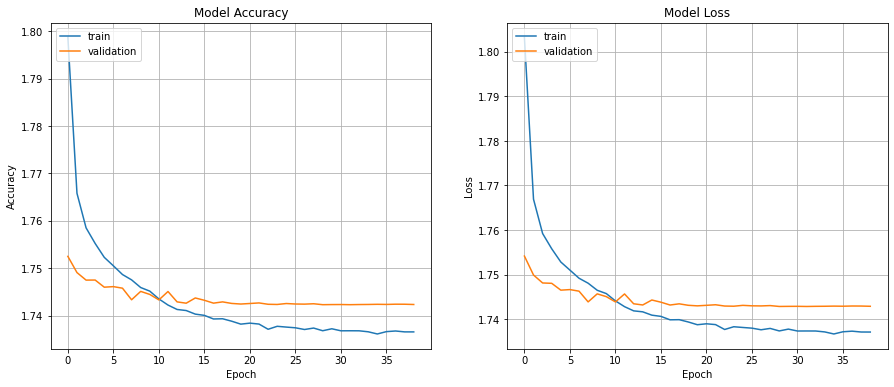

In [20]:
show_learning_curves(history)

In [21]:
# saving
model.save("purchot_neural_network_modified.h5")

In [22]:
X_test = test.iloc[:, 1:].values
test_pred = model.predict(X_test)
# saving the results
res = pd.DataFrame()
res['id'] = test['id']
res[['Class_' + str(i) for i in range(1, 10)]] = test_pred
res.to_csv('Purchot_modified_neural_network.csv', index=False)

In [26]:
classes = np.argmax(test_pred, axis=1)
test['target'] = classes.tolist()

In [27]:
y_values_train = train['target'].value_counts(
    normalize=True)
y_values_test = test['target'].value_counts(
    normalize=True)
x, y_test, y_train = np.arange(9), np.zeros(9), np.zeros(9)
y_test[y_values_test.index] = y_values_test.values
y_train[y_values_train.index-1] = y_values_train.values

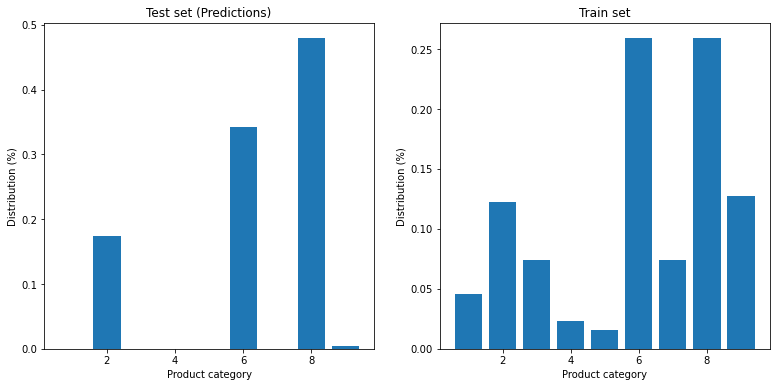

In [28]:
# display predicted and train classes distribution
fig, ax = plt.subplots(1, 2, figsize=(13, 6))
# first plot
ax[0].bar(x+1, y_test)
ax[0].set_title('Test set (Predictions)')
ax[0].set_xlabel('Product category')
ax[0].set_ylabel('Distribution (%)')
# second plot
ax[1].bar(x+1, y_train)
ax[1].set_title('Train set')
ax[1].set_xlabel('Product category')
ax[1].set_ylabel('Distribution (%)')
plt.show()